## VAEs - Normal Prior

In this notebook we train the VAE with NP and inspect its training behaviour.

### Objective

The elbo can be derived directly from K $KL(Q||P)$

\begin{align}
D_{KL}(q(z|x)||p(z|x)) &= \sum q(z|x) \log \frac{q(z|x)}{p(z|x)}\\
&= -\sum q(z|x) \log \frac{p(z|x)}{q(z|x)}\\
&= -\sum q(z|x)  \left[\log p(z|x) - \log q(z|x) \right]\\
&= -\sum q(z|x) \left[\log \frac{p(x|z)p(z)}{p(x)} - \log q(z|x) \right]\\
&= -\sum q(z|x) \left[\log p(x|z) + \log p(z) - \log p(x) - \log q(z|x) \right]\\
&= \sum q(z|x) \left[-\log p(x|z) - \log p(z) + \log p(x) + \log q(z|x) \right]\\
D_{KL}(q(z|x)||p(z|x)) - \sum q(z|x) \left[-\log p(x|z) - \log p(z) + \log q(z|x) \right] &= \log p(x)\\
-\sum q(z|x) \left[-\log p(x|z) + \log \frac{q(z|x)}{p(z)} \right] &= \\
-\mathbb{E}_{z \sim q(z|x)} \left[-\log p(x|z) + \log \frac{q(z|x)}{p(z)} \right] &=\\
-\mathbb{E}_{q} \left[-\log p(x|z) + \log \frac{q(z|x)}{p(z)} \right] &=\\
\mathbb{E}_{q} \left[\log p(x|z) - \log \frac{q(z|x)}{p(z)} \right] &=\\
D_{KL}(q(z|x)||p(z|x)) + \left[ \mathbb{E}_{q} \log p(x|z)  - \mathbb{E}_{q}  \log \frac{q(z|x)}{p(z)} \right] &= \log p(x)\\
\end{align}

$$
\max \mathbb{E}_{q} \log p(x|z)  - \mathbb{E}_{q}  \log \frac{q(z|x)}{p(z)} =
\min  - [\mathbb{E}_{q} \log p(x|z)  - \mathbb{E}_{q}  \log \frac{q(z|x)}{p(z)}]
$$


### Monte carlo loss
\begin{align}
-\mathbb{E}_{q} \log p(x|z)  + \mathbb{E}_{q}[ \log q(z|x) - \log p(z)]&= \\
\mathbb{E}_{q}[ \log q(z|x) - \log p(z)] - \mathbb{E}_{q} \log p(x|z)&=
\end{align}

\begin{align}
D_{KL}(q(z|x)||p(z|x)) + \left[ \mathbb{E}_{q} \log p(x|z)  - \mathbb{E}_{q}  \log \frac{q(z|x)}{p(z)} \right] &= \log p(x)
\end{align}


The first term is the original $D_{KL}$ we want to minimize, ($D_{KL}(q(z|x)||p(z|x))$). The second term is called the variational lower bound (ELBO).

$$
\max \mathcal{L} = \mathbb{E}_{q} \log p(x|z)  - \mathbb{E}_{q}  \log \frac{q(z|x)}{p(z)}
$$

Since $\log p(x)$ is a constant, and we want to minimize the $D_{KL}$ term, we can achieve the same by maximizing the ELBO.



In [ ]:
import torch
from IPython import display
from tqdm import tqdm
from torch import nn, optim
from torch.autograd.variable import Variable
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams["figure.figsize"] = (15, 7.5)
%config InlineBackend.figure_format='retina'

In [2]:
from training_tools import load_data, imshow, n_params
from myVAES import CNNEncoder, Encoder, Encoder3, Decoder, Decoder3, FlowPrior
from fid_score import FID, FID2

## A) MNIST

Training Parametarization :

In [3]:
dataset = {0 : "mnist", 1 : "svhn"}[0]
encoder_type = "dense"
eval_fid = False
latent_dim = 50
M = 171
lr = 0.0056
batch_size = 100
num_epochs = 50
input_shape = {"mnist" : (batch_size, 1,28,28),
               "svhn"  : (batch_size, 3,32,32)}[dataset]
expected_input_shape = (input_shape[0],
                        input_shape[1] * input_shape[2] * input_shape[3])

# parameter approximator for q(z|x)
encoder = Encoder3(expected_input_shape[-1], M, latent_dim).cuda()
# parameter approximator for p(x|z)
decoder = Decoder3(latent_dim, M, expected_input_shape[-1]).cuda()
# prior p(z|x)
p = torch.distributions.Normal(torch.zeros((batch_size, latent_dim)).cuda(),
                               torch.ones((batch_size, latent_dim)).cuda())


Total Parameters :

In [4]:
n_params(encoder) + n_params(decoder)

990804

In [5]:
X_, V_ = load_data(dataset, test=False, val_frac = .1)
N = X_.shape[0]
if N%batch_size:
    N = N - N%batch_size

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


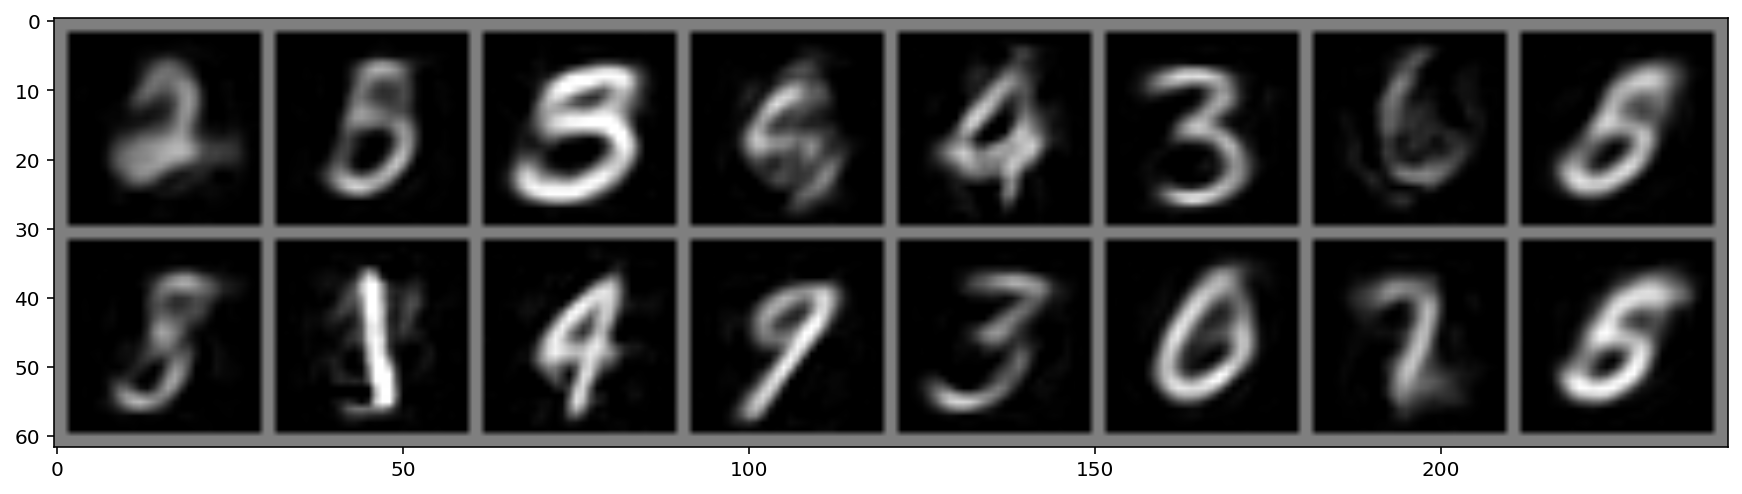

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:48<00:00,  3.36s/it]

Wall time: 2min 48s


In [6]:
%%time

# Optimizer
params = [param for param in list(encoder.parameters()) + list(decoder.parameters()) ]
optimizer = optim.Adam(params, lr=lr)

epochs = []
fids = []
n_batch = 1
sumdims = (1,2,3) if dataset == "svhn" else (1)
train_index = list(range(N))
for epoch in tqdm(range(num_epochs)):
    data = []
    fid = []
    np.random.shuffle(train_index)
    X_ = X_[train_index].cuda()
    for i in range(0, N, batch_size):
        X = X_[i:i+batch_size].reshape(expected_input_shape).float().cuda()
        
        optimizer.zero_grad()
        # Encode parameters of q
        mu_z, std_z = encoder(X)
        # sample from q(z|x)
        q = torch.distributions.Normal(mu_z, std_z)
        z = q.rsample().cuda()

   
        ####2 Reconstruction Error
        # Compute Likelihood 
        mu_x, std_x = decoder(z)
        # Compute the probability of x given xhat
        dist = torch.distributions.Normal(mu_x, std_x)
        log_pxz = dist.log_prob(X)
        # sum across channels, and all pixels (width, height)
        # this gives the log probability of THIS particular IMAGE
        log_pxz = log_pxz.sum(1)#.sum(dim=sumdims)
        # this is the gaussian likelihood
        recon_loss = log_pxz # * (1 + (1/n_batch**0.25)) 


        #### KL Loss

        q = torch.distributions.Normal(mu_z, std_z)
        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)


        # 3. calculate the KL

        # 4. this bit is a bit tricky. Since these are log probabilities
        # we can sum all the individual dimensions to give us the multi-dimensional
        # probability
        kl = (log_qzx - log_pz)
        kl = kl.sum(1) 
        elbo = (kl - recon_loss).sum()
        elbo.backward()
        optimizer.step()

        data += [{"elbo" : elbo.detach().item(),
                  "KL" : kl.detach().mean().item(),
                  "LL" : recon_loss.detach().mean().item()
                  }]
        n_batch += 1
        
    epochs.append(pd.DataFrame(data).mean())
    print("End of Epoch %s" % epoch)
    print(pd.DataFrame(data).mean())
    with torch.no_grad():
        display.clear_output(True)
        Z = p.rsample()
        mu_x, std_x = decoder(Z)
        #dist = torch.distributions.Normal(mu_x, 0)
        #sample = dist.rsample()
        sample = mu_x.reshape(batch_size,
                            input_shape[1],
                           input_shape[2],
                           input_shape[3])
        imshow(sample[:16])
        if eval_fid:
            # Compare with random sample from val
            real = V_[np.random.choice(list(range(V_.shape[0])), batch_size)]
            fid = FID2(real, sample, False)
            fids.append(fid)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

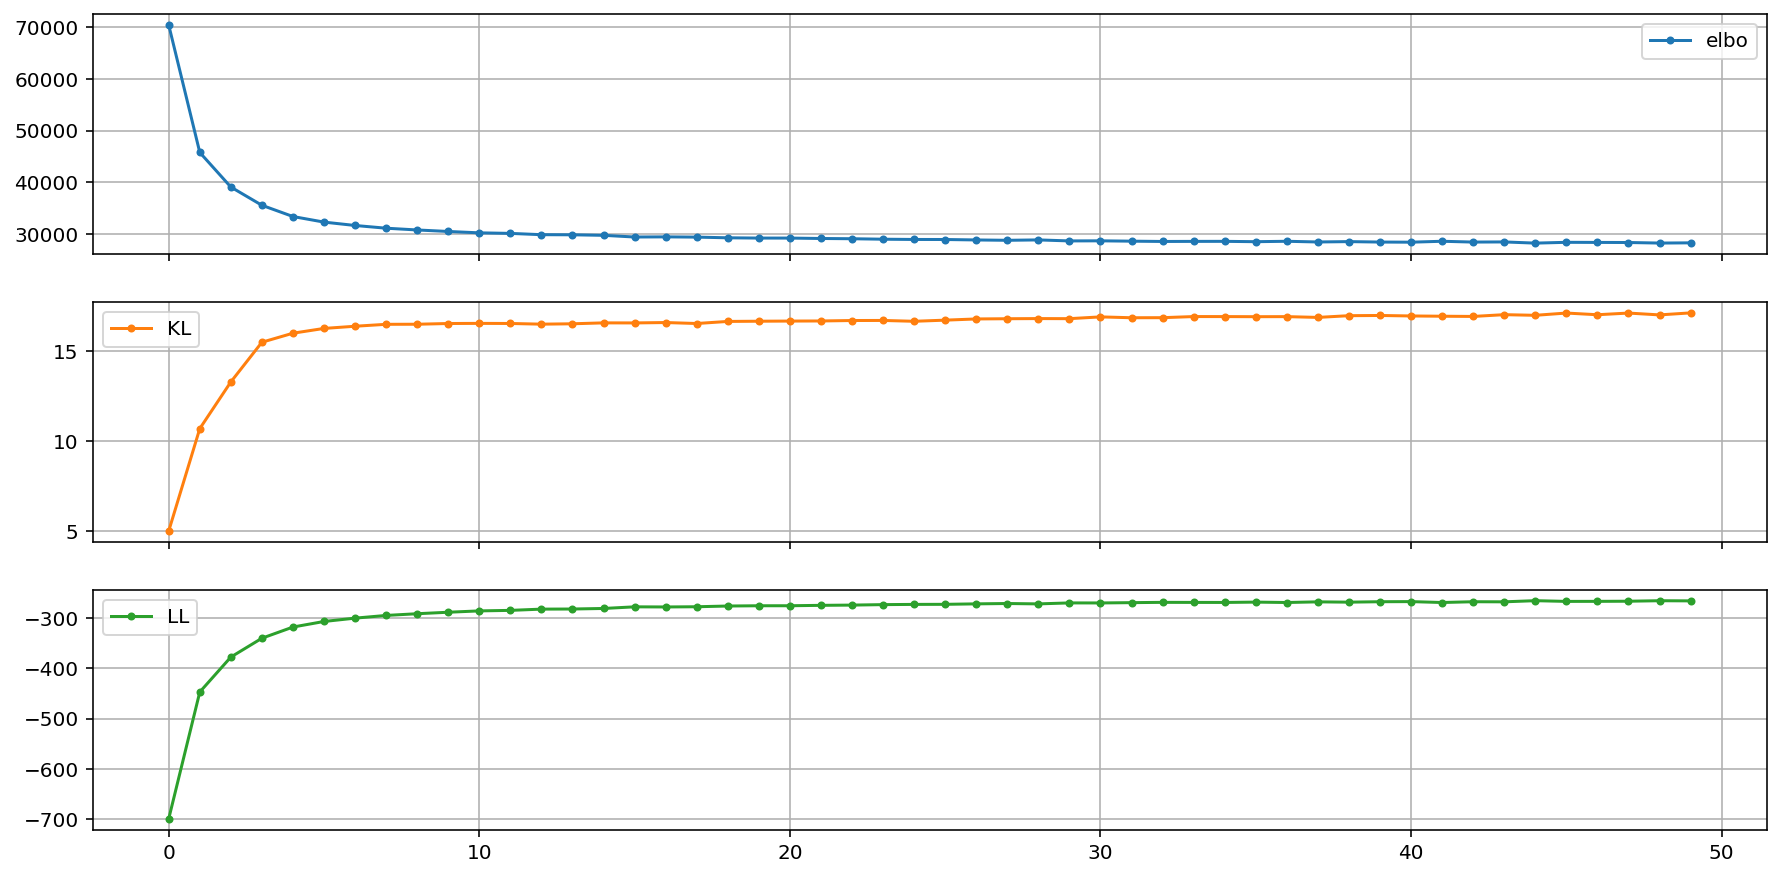

In [7]:
df = pd.DataFrame(epochs)
df["val_fid"] = fids if eval_fid else None
#df[["elbo","val_fid"]].plot(subplots=True, style=".-",grid=True)
df.plot(subplots=True, style=".-",grid=True)

## Example Images 

Generating from p:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


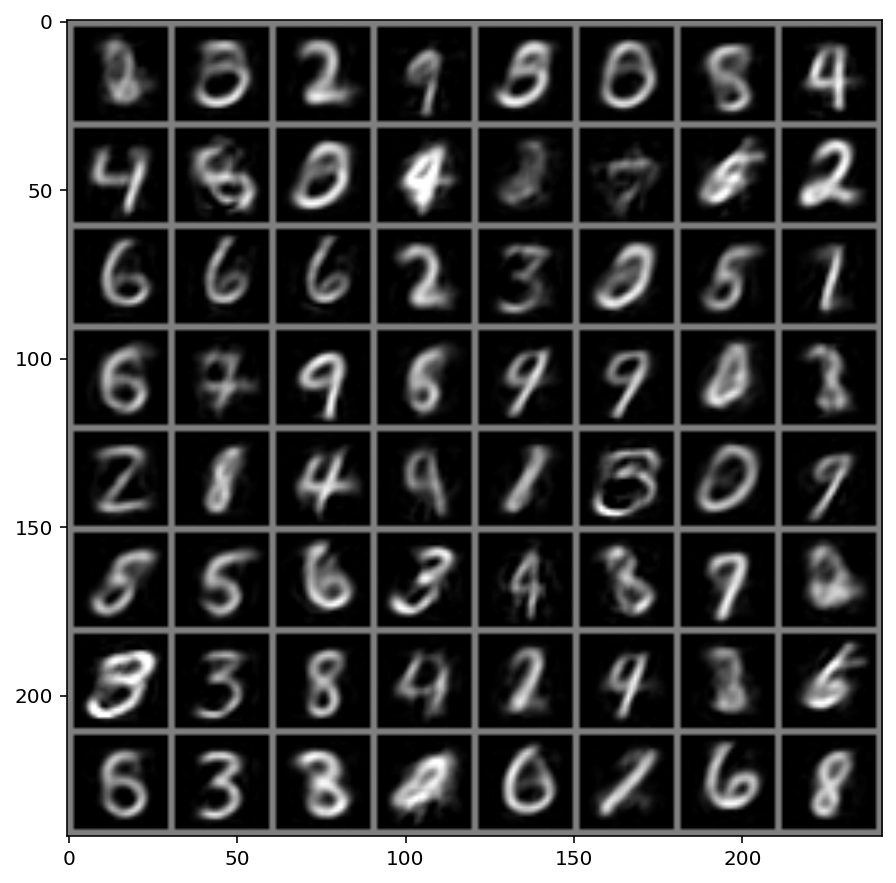

In [8]:
with torch.no_grad():
    s = 64
    Z = p.rsample()
    Xhat, _ = decoder(Z)
    imgs = Xhat[:s].reshape(s,
                        input_shape[1],
                       input_shape[2],
                       input_shape[3])
    imshow(imgs)

Reconstructing from q (not generating) :

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


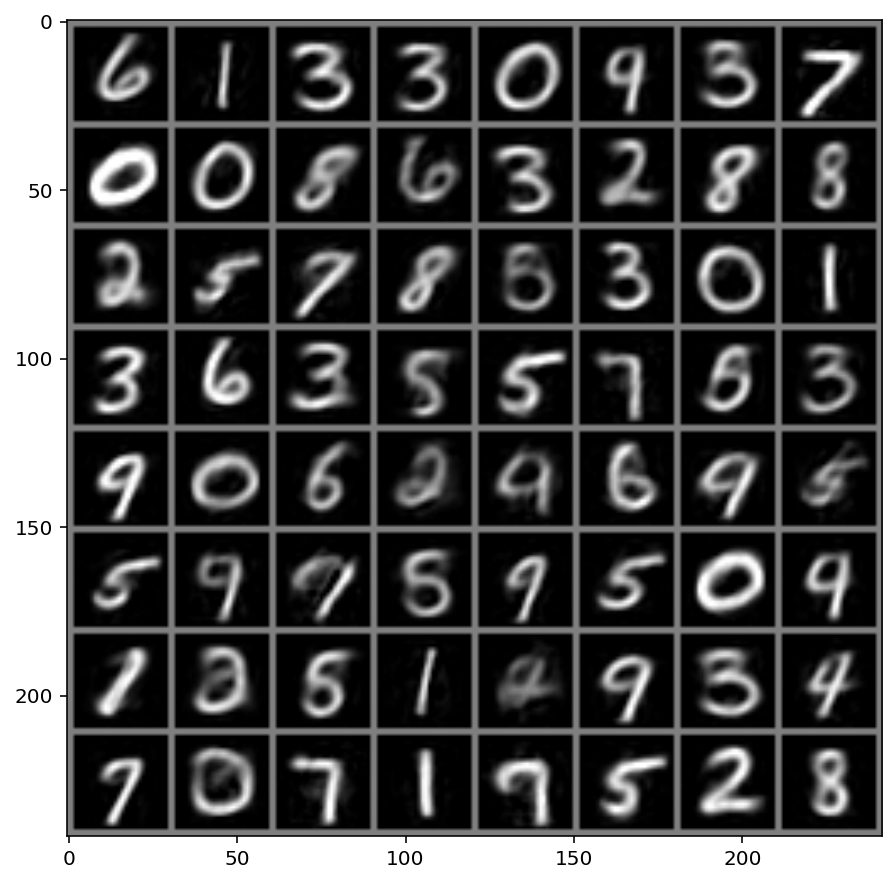

In [9]:
with torch.no_grad():
    s = 64
    Z = q.rsample()
    Xhat, _ = decoder(Z)
    imgs = Xhat[:s].reshape(s,
                        input_shape[1],
                       input_shape[2],
                       input_shape[3])
    imshow(imgs)

In [10]:
# Save model for inference
PATH = "mnist_NP_decoder.pt"
torch.save(decoder, PATH)

## B) SVHN

Training Parametarization :

In [11]:
dataset = {0 : "mnist", 1 : "svhn"}[1]
encoder_type = "dense"
eval_fid = False
latent_dim = 50
M = 171
lr = 0.0035
batch_size = 100
num_epochs = 50
input_shape = {"mnist" : (batch_size, 1,28,28),
               "svhn"  : (batch_size, 3,32,32)}[dataset]
expected_input_shape = (input_shape[0],
                        input_shape[1] * input_shape[2] * input_shape[3])

# parameter approximator for q(z|x)
encoder = Encoder3(expected_input_shape[-1], M, latent_dim).cuda()
# parameter approximator for p(x|z)
decoder = Decoder3(latent_dim, M, expected_input_shape[-1]).cuda()
# prior p(z|x)
p = torch.distributions.Normal(torch.zeros((batch_size, latent_dim)).cuda(),
                               torch.ones((batch_size, latent_dim)).cuda())


Total Parameters :

In [12]:
n_params(encoder) + n_params(decoder)

2949332

In [13]:
X_, V_ = load_data(dataset, test=False, val_frac = .1)
N = X_.shape[0]
if N%batch_size:
    N = N - N%batch_size

Using downloaded and verified file: ./SVHN/dataset\train_32x32.mat


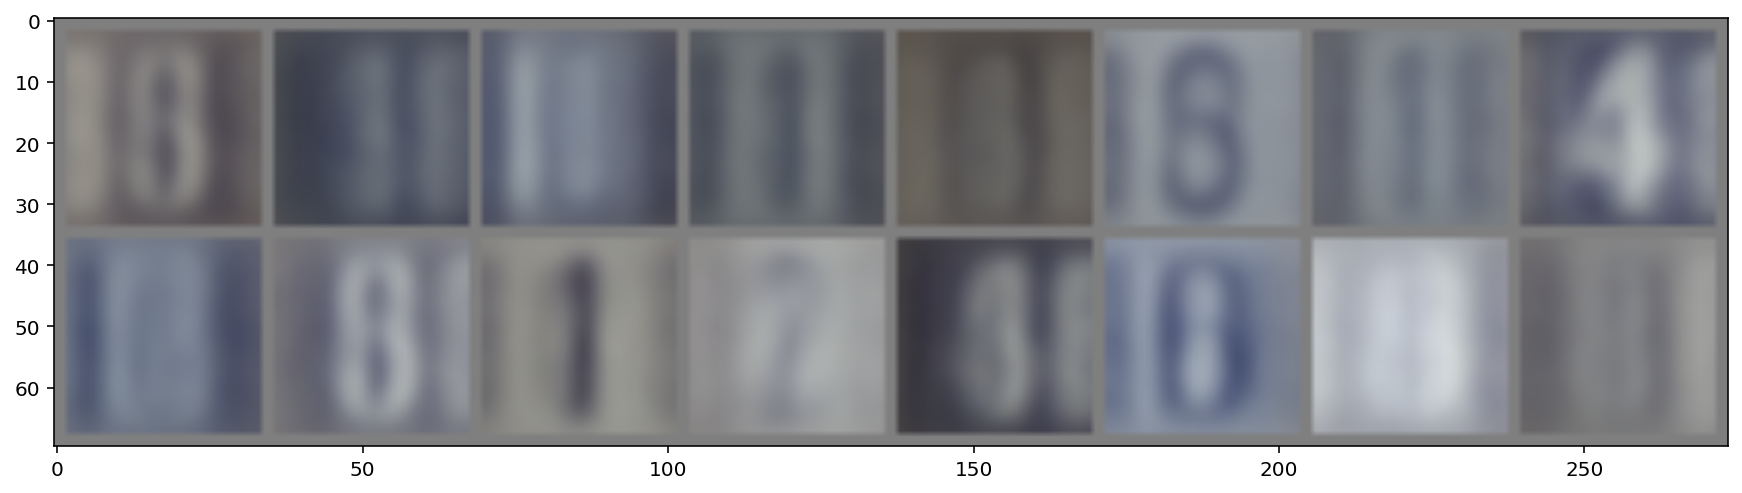

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [03:43<00:00,  4.46s/it]

Wall time: 3min 43s


In [14]:
%%time

# Optimizer
params = [param for param in list(encoder.parameters()) + list(decoder.parameters()) ]
optimizer = optim.Adam(params, lr=lr)

epochs = []
fids = []
n_batch = 1
sumdims = (1,2,3) if dataset == "svhn" else (1)
train_index = list(range(N))
for epoch in tqdm(range(num_epochs)):
    data = []
    fid = []
    np.random.shuffle(train_index)
    X_ = X_[train_index].cuda()
    for i in range(0, N, batch_size):
        X = X_[i:i+batch_size].reshape(expected_input_shape).float().cuda()
        
        optimizer.zero_grad()
        # Encode parameters of q
        mu_z, std_z = encoder(X)
        # sample from q(z|x)
        q = torch.distributions.Normal(mu_z, std_z)
        z = q.rsample().cuda()

   
        ####2 Reconstruction Error
        # Compute Likelihood 
        mu_x, std_x = decoder(z)
        # Compute the probability of x given xhat
        dist = torch.distributions.Normal(mu_x, std_x)
        log_pxz = dist.log_prob(X)
        # sum across channels, and all pixels (width, height)
        # this gives the log probability of THIS particular IMAGE
        log_pxz = log_pxz.sum(1)#.sum(dim=sumdims)
        # this is the gaussian likelihood
        recon_loss = log_pxz # * (1 + (1/n_batch**0.25)) 


        #### KL Loss

        q = torch.distributions.Normal(mu_z, std_z)
        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)


        # 3. calculate the KL

        # 4. this bit is a bit tricky. Since these are log probabilities
        # we can sum all the individual dimensions to give us the multi-dimensional
        # probability
        kl = (log_qzx - log_pz)
        kl = kl.sum(1) 
        elbo = (kl - recon_loss).sum()
        elbo.backward()
        optimizer.step()

        data += [{"elbo" : elbo.detach().item(),
                  "KL" : kl.detach().mean().item(),
                  "LL" : recon_loss.detach().mean().item()
                  }]
        n_batch += 1
        
    epochs.append(pd.DataFrame(data).mean())
    print("End of Epoch %s" % epoch)
    print(pd.DataFrame(data).mean())
    with torch.no_grad():
        display.clear_output(True)
        Z = p.rsample()
        mu_x, std_x = decoder(Z)
        #dist = torch.distributions.Normal(mu_x, 0)
        #sample = dist.rsample()
        sample = mu_x.reshape(batch_size,
                            input_shape[1],
                           input_shape[2],
                           input_shape[3])
        imshow(sample[:16])
        if eval_fid:
            # Compare with random sample from val
            real = V_[np.random.choice(list(range(V_.shape[0])), batch_size)]
            print(sample.shape, real.shape)
            fid = FID2(real, sample, False)
            fids.append(fid)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

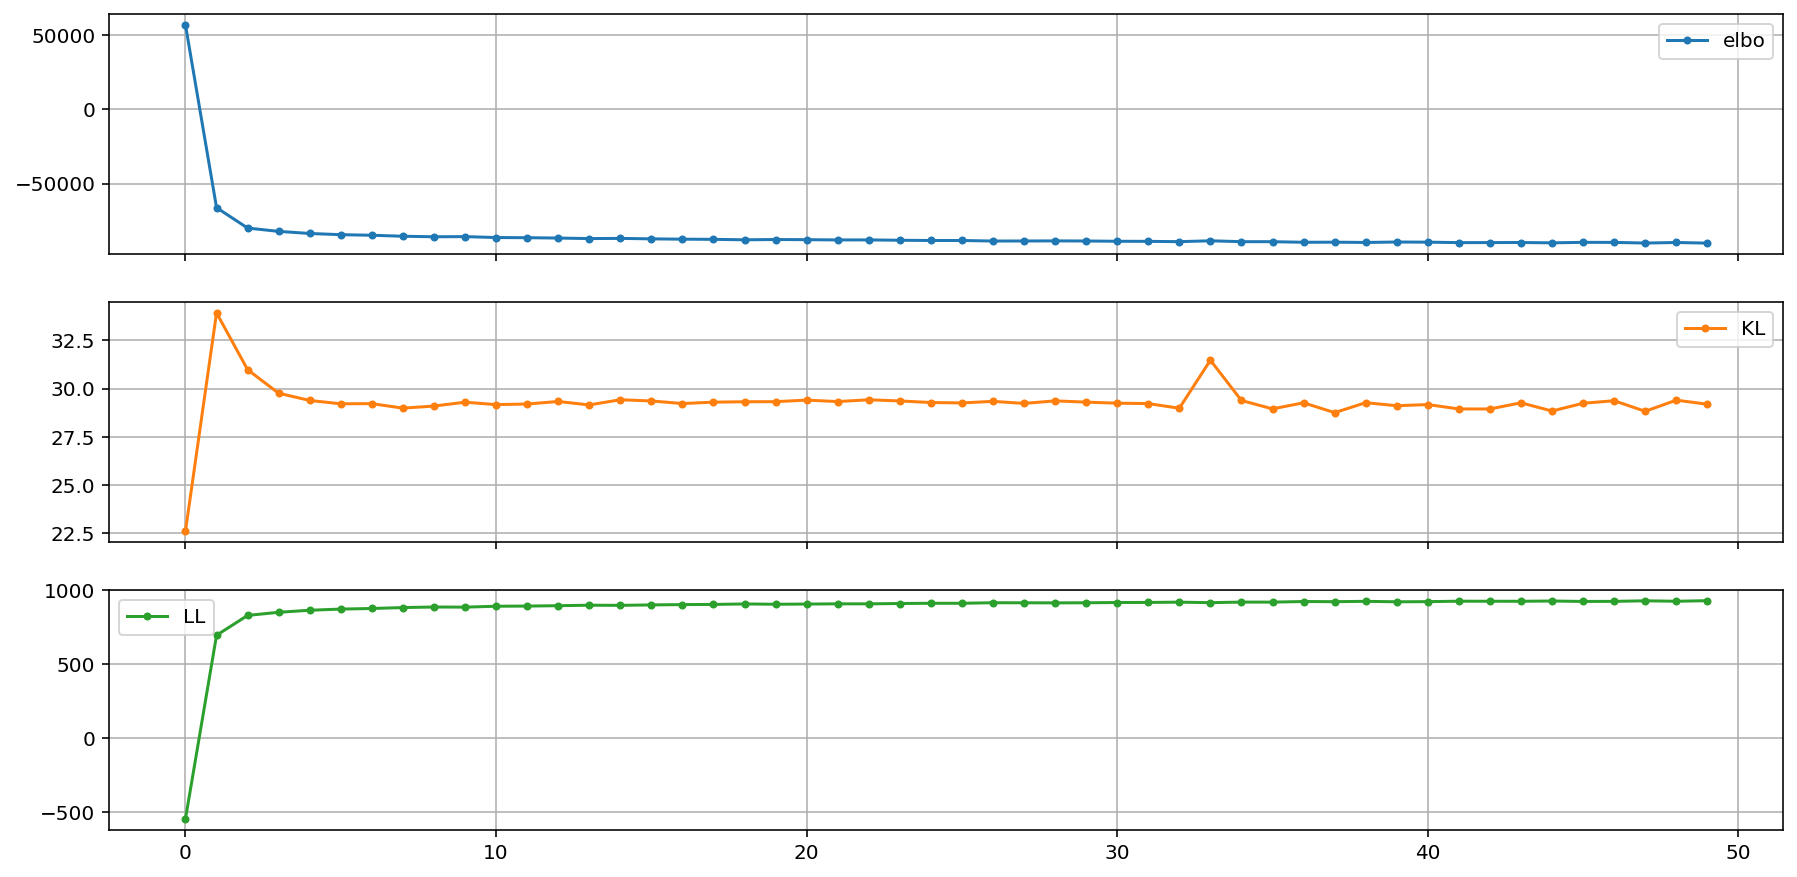

In [15]:
df = pd.DataFrame(epochs)
df["val_fid"] = fids if eval_fid else None
#df[["elbo","val_fid"]].plot(subplots=True, style=".-",grid=True)
df.plot(subplots=True, style=".-",grid=True)

## Example Images 

Generating from p:

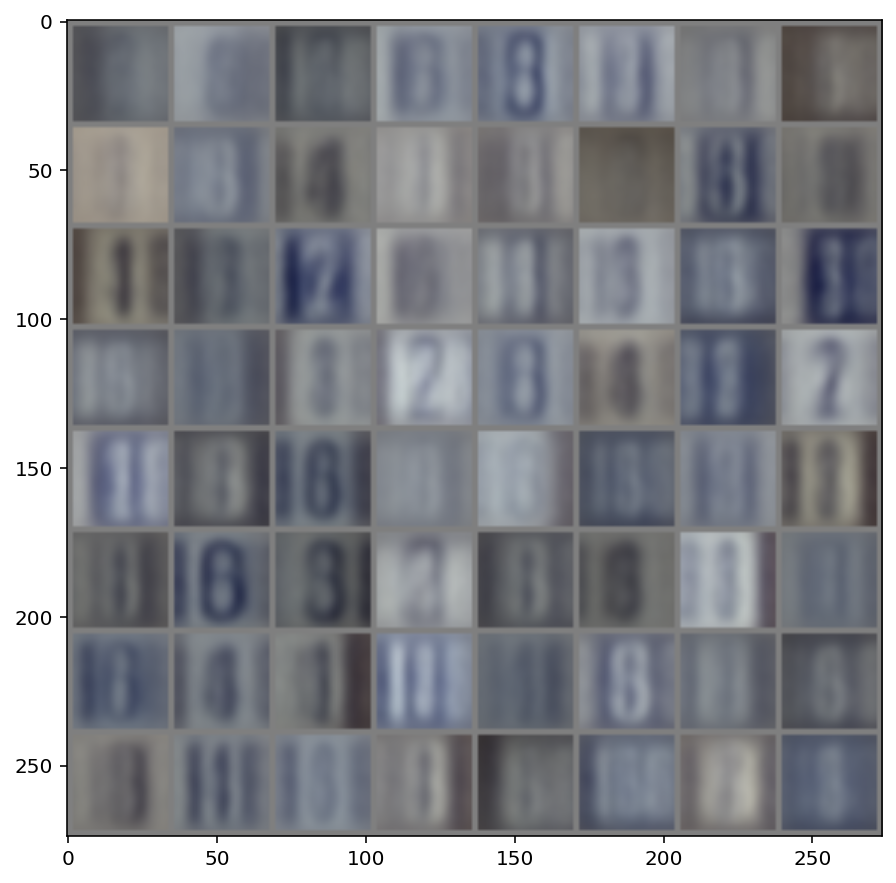

In [17]:
with torch.no_grad():
    s = 64
    Z = p.rsample()
    Xhat, _ = decoder(Z)
    imgs = Xhat[:s].reshape(s,
                        input_shape[1],
                       input_shape[2],
                       input_shape[3])
    imshow(imgs)

Reconstructing from q (not generating) :

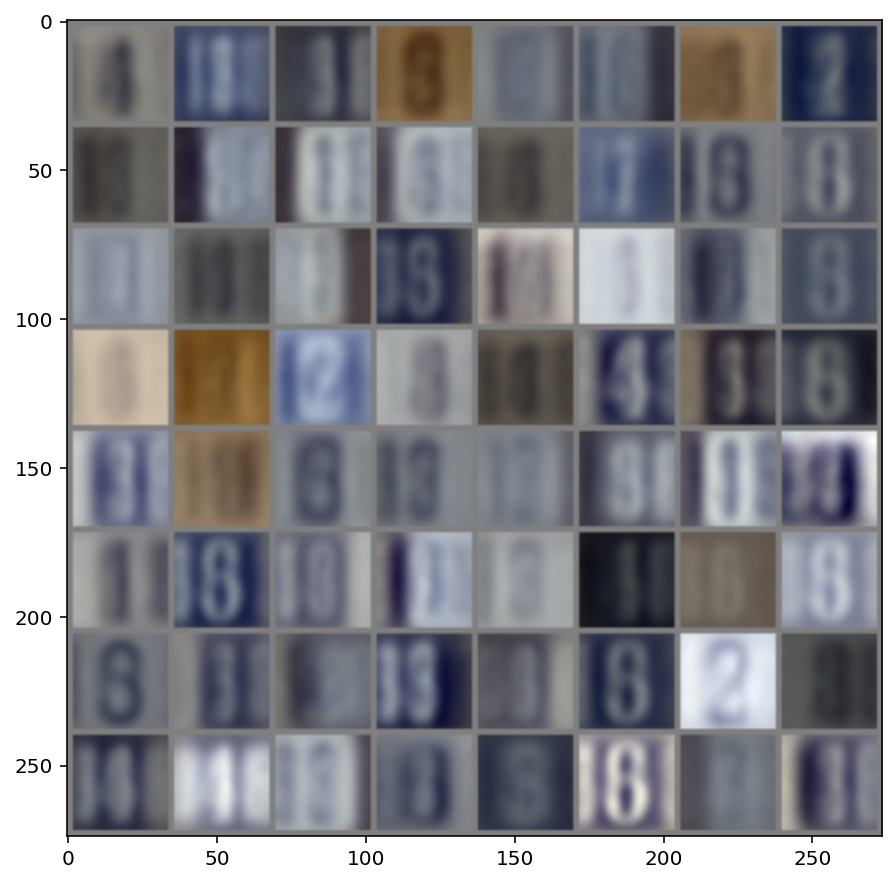

In [18]:
with torch.no_grad():
    s = 64
    Z = q.rsample()
    Xhat, _ = decoder(Z)
    imgs = Xhat[:s].reshape(s,
                        input_shape[1],
                       input_shape[2],
                       input_shape[3])
    imshow(imgs)

In [19]:
# Save model for inference
PATH = "svhn_NP_decoder.pt"
torch.save(decoder, PATH)

## Conclusive Note on training the VAE + NP
We can see that optimizing the elbo works reasonable. However we noticed that sometimes the KL gets outweighted by the reconstruction error, meaning, the model is focusing too much on reconstruction and very little on forcing the latent space to be normal. We can nicely observe this by comparing reconstructed samples with generated samples, i.e. drawing from q(z|x) vs drawing from p(z).


Training the vanilla VAE turned out to be very smooth. The model is relatively insensitive to hyperparameters and yields good results out of the box using a small set of parameters. Our implementation is not perfect, but it works quite good and is very general. An interesting thing that makes little sense is that we sometimes observed better image qualities when using smaller latent space representations, for example 10.

# 